In [1]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.infogram import H2OInfogram
from h2o.estimators.gbm import H2OGradientBoostingEstimator
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '..')
from DataModule.Data_Preparation import CoronnaCERTAINDataset
import EvaluationModule
import EvaluationModule_H2O
pd.options.mode.chained_assignment = None

(CVXPY) Jul 25 11:34:16 AM: Encountered unexpected exception importing solver CVXOPT:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 25 11:34:16 AM: Encountered unexpected exception importing solver GLPK:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 25 11:34:16 AM: Encountered unexpected exception importing solver GLPK_MI:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/e

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [9]:
dataset = CoronnaCERTAINDataset(
    library_root = '/Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/',
    challenge = 'binary_classification', #option: regression, regression_delta, classification, binary_classification, regression_delta_binary
    dataset = 'CORRONA CERTAIN', 
    process_approach = 'SC', #option: KVB, SC
    imputation = 'IterativeImputer', #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD, None(raw)
    patient_group = ['bionaive TNF'], #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group = 'all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points = (0,3), 
    train_test_rate = 0.8,
    remove_low_DAS = True,
    save_csv = False, 
    random_state = 2022,
    verbose=False)

In [10]:
train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

In [11]:
# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
# train_h2o = h2o.upload_file(str(train_loc))
# test_h2o = h2o.upload_file(str(test_loc))
train_h2o = h2o.import_file(str(train_loc))
test_h2o = h2o.import_file(str(test_loc))

# Identify predictors and response
x = train_h2o.columns[:-1]
# y = "DAS28_CRP_3M"
y = dataset.target

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,11 hours 31 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 month and 28 days
H2O_cluster_name:,H2O_from_python_gaskell_eq645x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.869 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [12]:
for feature in dataset.categorical:
    train_h2o[feature] = train_h2o[feature].asfactor()
    test_h2o[feature] = test_h2o[feature].asfactor()
if "classification" in dataset.challenge:
    train_h2o[y] = train_h2o[y].asfactor()
    test_h2o[y] = test_h2o[y].asfactor()

In [27]:
# Run AutoML for 20 base models
# aml = H2OAutoML(max_models = 100, nfolds=10, balance_classes=True, max_after_balance_size=2.0, seed = 2022, project_name = "SC_classification_Jul24")
aml = H2OAutoML(max_models = 10, max_runtime_secs=60, nfolds=3, balance_classes=True, max_after_balance_size=2, stopping_metric='misclassification', sort_metric='f1', seed = 2022, project_name = "SC_classification_Jul24_3")
aml.train(x=x, y=y, training_frame=train_h2o)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
11:56:35.709: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]


11:56:37.38: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]

█
11:56:37.800: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]

█
11:56:38.843: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]


11:56:39.223: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]

██
11:56:39.958: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]
11:56:40.601: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]
11:56:41.205: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_grou

model_id,f1,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_3_AutoML_5_20220725_115635,0.863551,0.581806,0.635566,0.805658,0.5,0.443531,0.196719
StackedEnsemble_AllModels_1_AutoML_5_20220725_115635,0.863551,0.433493,0.557984,0.719977,0.5,0.429865,0.184784
GLM_1_AutoML_5_20220725_115635,0.863551,0.495523,0.552144,0.75486,0.5,0.427558,0.182805
XGBoost_2_AutoML_5_20220725_115635,0.863551,0.559924,0.6751,0.787701,0.5,0.48919,0.239307
DRF_1_AutoML_5_20220725_115635,0.863551,0.600931,0.6079,0.809843,0.5,0.439016,0.192735
GBM_2_AutoML_5_20220725_115635,0.863551,0.613473,0.631983,0.81079,0.5,0.439955,0.193561
XGBoost_1_AutoML_5_20220725_115635,0.863551,0.481943,0.687892,0.75261,0.5,0.497366,0.247373
GBM_4_AutoML_5_20220725_115635,0.863551,0.607306,0.613787,0.804692,0.5,0.435811,0.189931
XRT_1_AutoML_5_20220725_115635,0.864662,0.555358,0.623964,0.796314,0.488466,0.442995,0.196244
XGBoost_3_AutoML_5_20220725_115635,0.865169,0.595208,0.638002,0.818205,0.493151,0.469501,0.220431


In [28]:
model_id_prefix = []
model_id_list = []
for model_id in lb.as_data_frame()['model_id'].values.tolist():
    if model_id.split('_')[0] not in model_id_prefix:
        model_id_prefix.append(model_id.split('_')[0])
        model_id_list.append(model_id)
    if len(model_id_list) > 10:
        break
model_id_list

['GBM_3_AutoML_5_20220725_115635',
 'StackedEnsemble_AllModels_1_AutoML_5_20220725_115635',
 'GLM_1_AutoML_5_20220725_115635',
 'XGBoost_2_AutoML_5_20220725_115635',
 'DRF_1_AutoML_5_20220725_115635',
 'XRT_1_AutoML_5_20220725_115635']

In [29]:
model = h2o.get_model('GBM_3_AutoML_3_20220725_113730')
cv_df = model.cross_validation_metrics_summary().as_data_frame()
cv_df

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,accuracy,0.763185,0.016493,0.754902,0.782178,0.752475
1,auc,0.640198,0.053339,0.689271,0.583429,0.647895
2,err,0.236815,0.016493,0.245098,0.217822,0.247525
3,err_count,24.000000,1.732051,25.000000,22.000000,25.000000
4,f0point5,0.800380,0.015091,0.791667,0.817805,0.791667
5,f1,0.865097,0.010982,0.858757,0.877778,0.858757
6,f2,0.941262,0.005179,0.938272,0.947242,0.938272
7,lift_top_group,1.103431,0.402055,1.342105,0.639240,1.328947
8,logloss,0.567508,0.018790,0.546260,0.574329,0.581935
9,max_per_class_error,0.987179,0.022206,0.961538,1.000000,1.000000


In [24]:
results_df = pd.DataFrame(columns=['dataset','challenge', 'model_id', 'accuracy_mean', 'accuracy_std', 'auc_mean', 'auc_std', 'f1_mean', 'f1_std'])
for model_id in model_id_list:
    model = h2o.get_model(model_id)
    cv_df = model.cross_validation_metrics_summary().as_data_frame().set_index('')
    acc_mean, acc_std = cv_df.loc['accuracy','mean'], np.std(cv_df.loc['accuracy','cv_1_valid':'cv_3_valid'])
    auc_mean, auc_std = cv_df.loc['auc','mean'], np.std(cv_df.loc['auc','cv_1_valid':'cv_3_valid'])
    f1_mean, f1_std = cv_df.loc['f1','mean'], np.std(cv_df.loc['f1','cv_1_valid':'cv_3_valid'])
    results_list = ['val', dataset.challenge, model_id, acc_mean, acc_std, auc_mean, auc_std, f1_mean, f1_std]
    results_df.loc[len(results_df)] = results_list
    
results_df

,dataset,challenge,model_id,accuracy_mean,accuracy_std,auc_mean,auc_std,f1_mean,f1_std
0,val,binary_classification,GBM_3_AutoML_3_20220725_113730,0.763185,0.013467,0.640198,0.043551,0.865097,0.008966
1,val,binary_classification,DRF_1_AutoML_3_20220725_113730,0.776354,0.008237,0.632541,0.045134,0.865799,0.009197
2,val,binary_classification,XRT_1_AutoML_3_20220725_113730,0.786126,0.013217,0.628815,0.071898,0.874783,0.005512
3,val,binary_classification,StackedEnsemble_BestOfFamily_1_AutoML_3_20220725_113730,0.766663,0.032088,0.644759,0.070417,0.865917,0.021728
4,val,binary_classification,XGBoost_2_AutoML_3_20220725_113730,0.776322,0.004240,0.577167,0.089463,0.870615,0.005218
5,val,binary_classification,GLM_1_AutoML_3_20220725_113730,0.763185,0.013467,0.524470,0.055200,0.865097,0.008966


In [30]:
aml.leader.model_performance(test_h2o)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.2158298742591587
RMSE: 0.46457493933611904
LogLoss: 0.6853007007840722
Mean Per-Class Error: 0.3616666666666667
AUC: 0.6373333333333333
AUCPR: 0.7953850715863114
Gini: 0.2746666666666666

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.721008834663345: 


,,0,1,Error,Rate
0,0,9.0,16.0,0.64,(16.0/25.0)
1,1,5.0,55.0,0.0833,(5.0/60.0)
2,Total,14.0,71.0,0.2471,(21.0/85.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.721009,0.839695,70.0
1,max f2,0.391587,0.923077,84.0
2,max f0point5,0.785773,0.807927,66.0
3,max accuracy,0.785773,0.752941,66.0
4,max precision,0.981687,1.000000,0.0
5,max recall,0.391587,1.000000,84.0
6,max specificity,0.981687,1.000000,0.0
7,max absolute_mcc,0.785773,0.360597,66.0
8,max min_per_class_accuracy,0.909007,0.600000,44.0
9,max mean_per_class_accuracy,0.785773,0.661667,66.0



Gains/Lift Table: Avg response rate: 70.59 %, avg score: 85.04 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011765,0.979829,1.416667,1.416667,1.000000,0.981687,1.000000,0.981687,0.016667,0.016667,41.666667,41.666667,0.016667
1,2,0.023529,0.978837,1.416667,1.416667,1.000000,0.979475,1.000000,0.980581,0.016667,0.033333,41.666667,41.666667,0.033333
2,3,0.035294,0.975484,1.416667,1.416667,1.000000,0.978536,1.000000,0.979899,0.016667,0.050000,41.666667,41.666667,0.050000
3,4,0.047059,0.972587,1.416667,1.416667,1.000000,0.972667,1.000000,0.978091,0.016667,0.066667,41.666667,41.666667,0.066667
4,5,0.058824,0.972124,0.000000,1.133333,0.000000,0.972444,0.800000,0.976962,0.000000,0.066667,-100.000000,13.333333,0.026667
5,6,0.105882,0.963232,1.062500,1.101852,0.750000,0.967241,0.777778,0.972641,0.050000,0.116667,6.250000,10.185185,0.036667
6,7,0.152941,0.959976,1.416667,1.198718,1.000000,0.962217,0.846154,0.969434,0.066667,0.183333,41.666667,19.871795,0.103333
7,8,0.200000,0.956064,1.062500,1.166667,0.750000,0.957710,0.823529,0.966675,0.050000,0.233333,6.250000,16.666667,0.113333
8,9,0.305882,0.943668,1.101852,1.144231,0.777778,0.949662,0.807692,0.960786,0.116667,0.350000,10.185185,14.423077,0.150000
9,10,0.400000,0.927595,0.708333,1.041667,0.500000,0.935055,0.735294,0.954732,0.066667,0.416667,-29.166667,4.166667,0.056667


In [52]:
# dir(m)

In [21]:
# aml_sc.saved_model

In [ ]:
# aml_sc = evaluate.AutoBuild(seed=1, project_name="EHR_RA_SC")
# test, test_loc = dataset.get_test()
# baseline = test['DAS28_CRP_0M']
# true = test['DAS28_CRP_3M']

In [ ]:
# pred = pred.as_data_frame()

In [22]:
perf = aml.leader.model_performance(train_h2o)
perf


ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 0.47536937045789057
RMSE: 0.6894703550247034
MAE: 0.5362376985507772
RMSLE: NaN
Mean Residual Deviance: 0.47536937045789057


In [33]:
perf = aml.leader.model_performance(test_h2o)
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.2158298742591587
RMSE: 0.46457493933611904
LogLoss: 0.6853007007840722
Mean Per-Class Error: 0.3616666666666667
AUC: 0.6373333333333333
AUCPR: 0.7953850715863114
Gini: 0.2746666666666666

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.721008834663345: 


,,0,1,Error,Rate
0,0,9.0,16.0,0.64,(16.0/25.0)
1,1,5.0,55.0,0.0833,(5.0/60.0)
2,Total,14.0,71.0,0.2471,(21.0/85.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.721009,0.839695,70.0
1,max f2,0.391587,0.923077,84.0
2,max f0point5,0.785773,0.807927,66.0
3,max accuracy,0.785773,0.752941,66.0
4,max precision,0.981687,1.000000,0.0
5,max recall,0.391587,1.000000,84.0
6,max specificity,0.981687,1.000000,0.0
7,max absolute_mcc,0.785773,0.360597,66.0
8,max min_per_class_accuracy,0.909007,0.600000,44.0
9,max mean_per_class_accuracy,0.785773,0.661667,66.0



Gains/Lift Table: Avg response rate: 70.59 %, avg score: 85.04 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011765,0.979829,1.416667,1.416667,1.000000,0.981687,1.000000,0.981687,0.016667,0.016667,41.666667,41.666667,0.016667
1,2,0.023529,0.978837,1.416667,1.416667,1.000000,0.979475,1.000000,0.980581,0.016667,0.033333,41.666667,41.666667,0.033333
2,3,0.035294,0.975484,1.416667,1.416667,1.000000,0.978536,1.000000,0.979899,0.016667,0.050000,41.666667,41.666667,0.050000
3,4,0.047059,0.972587,1.416667,1.416667,1.000000,0.972667,1.000000,0.978091,0.016667,0.066667,41.666667,41.666667,0.066667
4,5,0.058824,0.972124,0.000000,1.133333,0.000000,0.972444,0.800000,0.976962,0.000000,0.066667,-100.000000,13.333333,0.026667
5,6,0.105882,0.963232,1.062500,1.101852,0.750000,0.967241,0.777778,0.972641,0.050000,0.116667,6.250000,10.185185,0.036667
6,7,0.152941,0.959976,1.416667,1.198718,1.000000,0.962217,0.846154,0.969434,0.066667,0.183333,41.666667,19.871795,0.103333
7,8,0.200000,0.956064,1.062500,1.166667,0.750000,0.957710,0.823529,0.966675,0.050000,0.233333,6.250000,16.666667,0.113333
8,9,0.305882,0.943668,1.101852,1.144231,0.777778,0.949662,0.807692,0.960786,0.116667,0.350000,10.185185,14.423077,0.150000
9,10,0.400000,0.927595,0.708333,1.041667,0.500000,0.935055,0.735294,0.954732,0.066667,0.416667,-29.166667,4.166667,0.056667


In [28]:
# aml_sc.saved_model

In [29]:
# aml_sc.evaluate('XGBoost_lr_search_selection_AutoML_1_20220724_222904_select_grid_model_1', aml.leader, "test", testset, aml_sc.test_perf)

In [40]:
model = aml.leader
true = test[dataset.target]
X = test.drop(columns=dataset.target)
X = h2o.H2OFrame(X)
pred = model.predict(X).as_data_frame()['predict']
pred

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


0     1.255168
1     2.286309
2     2.392133
3     0.812751
4     1.259574
        ...   
80    1.178084
81    0.396744
82    1.674447
83    1.862879
84    1.558436
Name: predict, Length: 85, dtype: float64

In [41]:
from sklearn import metrics
metrics.mean_squared_error(true, pred)

1.3413230520336332

In [33]:
model.predict(test_h2o)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


predict
1.25517
2.28631
2.39213
0.812751
1.25957
1.08353
2.06492
1.15485
1.90849
1.48913


In [31]:
aml.leader.predict(test_h2o)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


predict,p0,p1
1,0.164057,0.835943
1,0.0909932,0.909007
1,0.0273329,0.972667
1,0.0956168,0.904383
1,0.0793568,0.920643
1,0.0326829,0.967317
1,0.0275564,0.972444
1,0.13354,0.86646
1,0.11068,0.88932
1,0.0906443,0.909356


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_3_AutoML_5_20220725_115635


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.721008834663345: 


,,0,1,Error,Rate
0,0,9.0,16.0,0.64,(16.0/25.0)
1,1,5.0,55.0,0.0833,(5.0/60.0)
2,Total,14.0,71.0,0.2471,(21.0/85.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

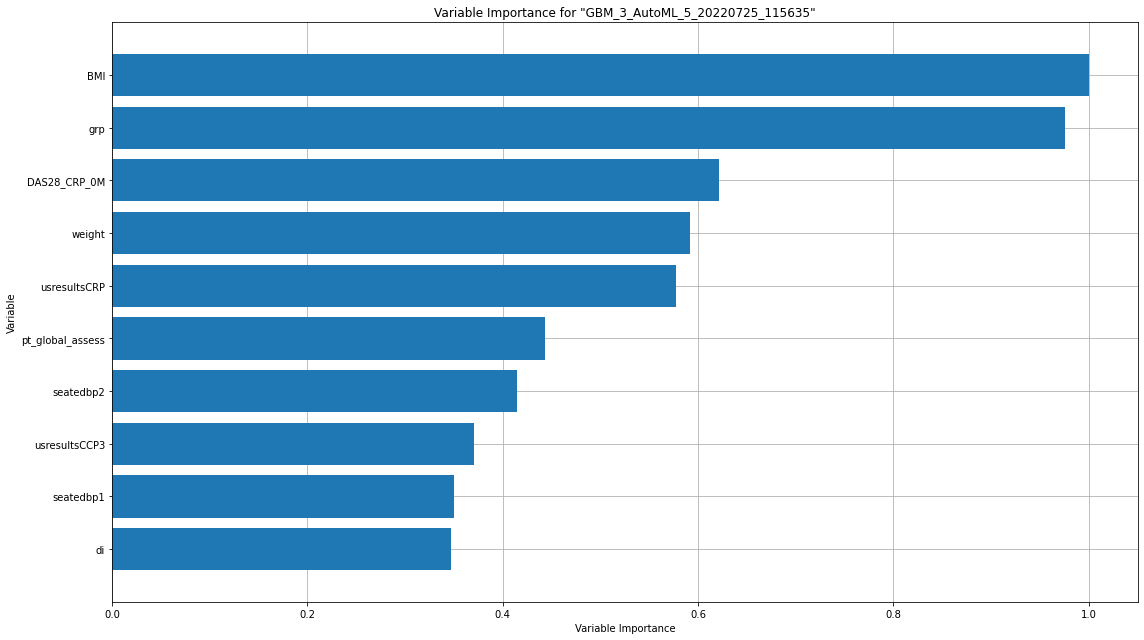

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


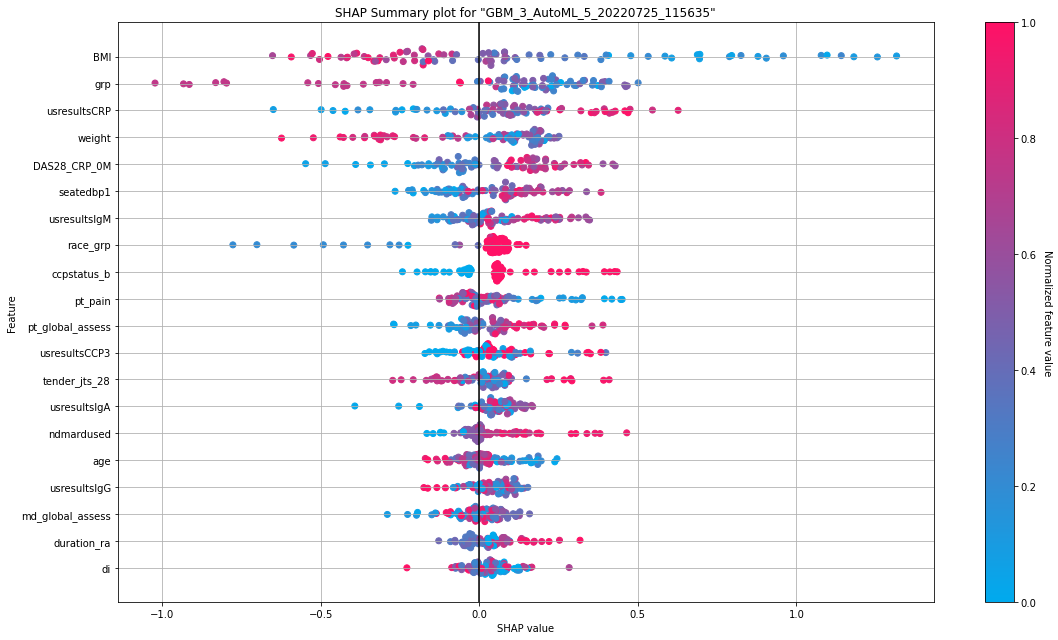

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

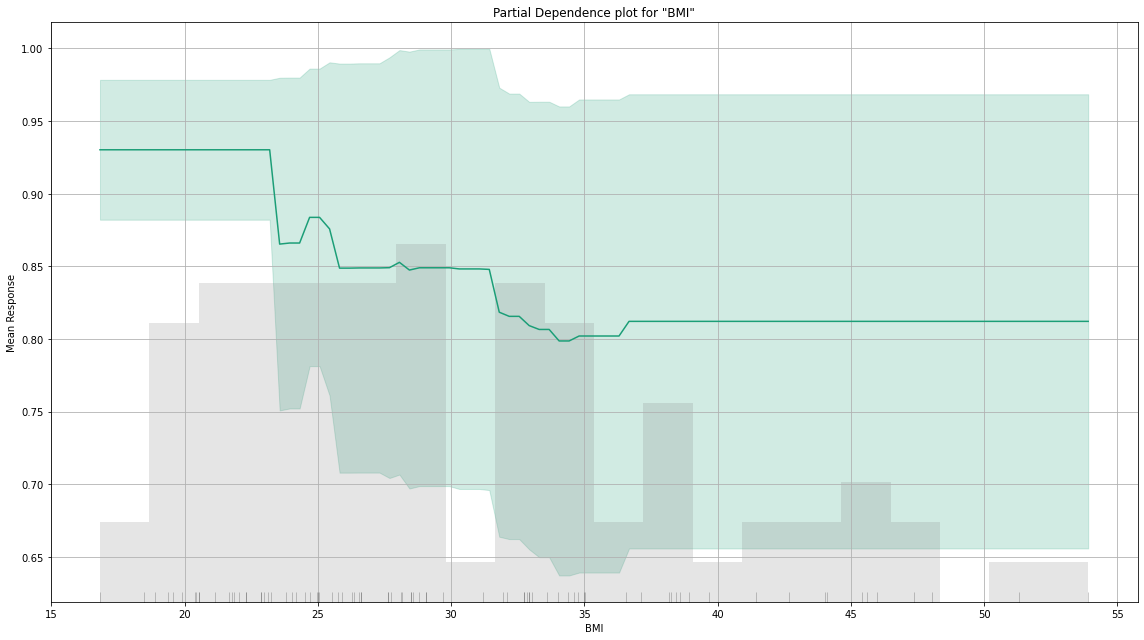

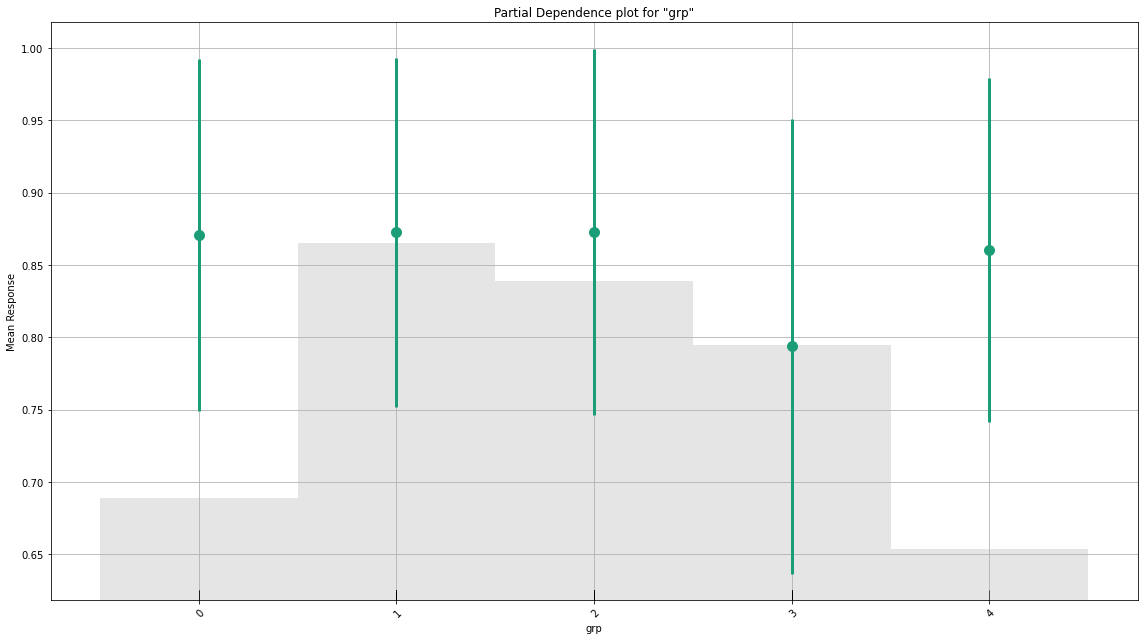

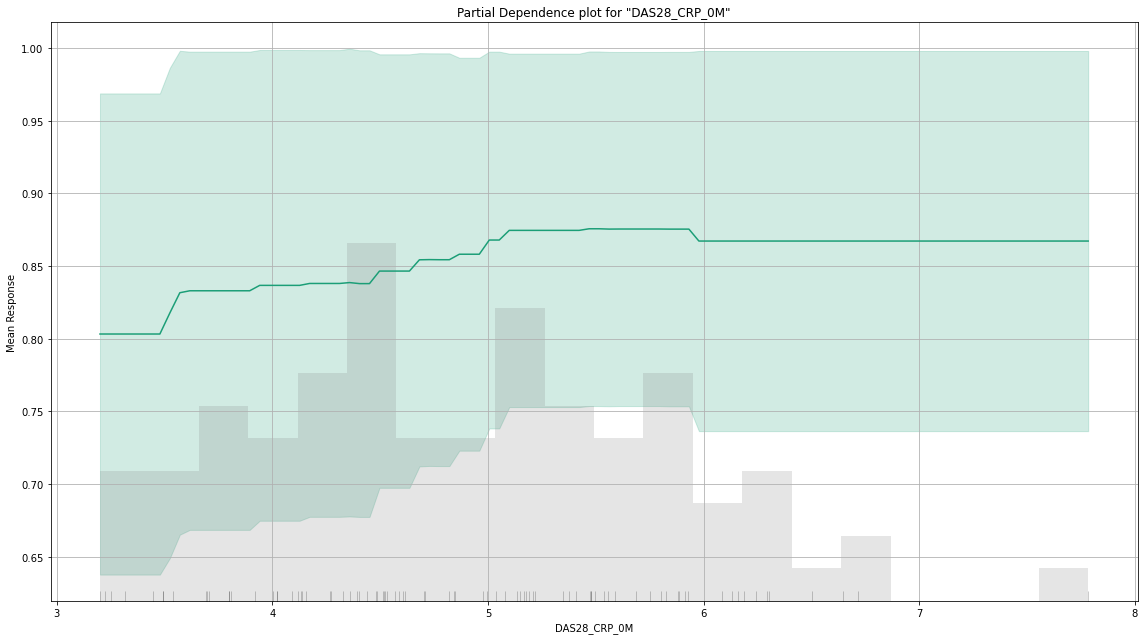

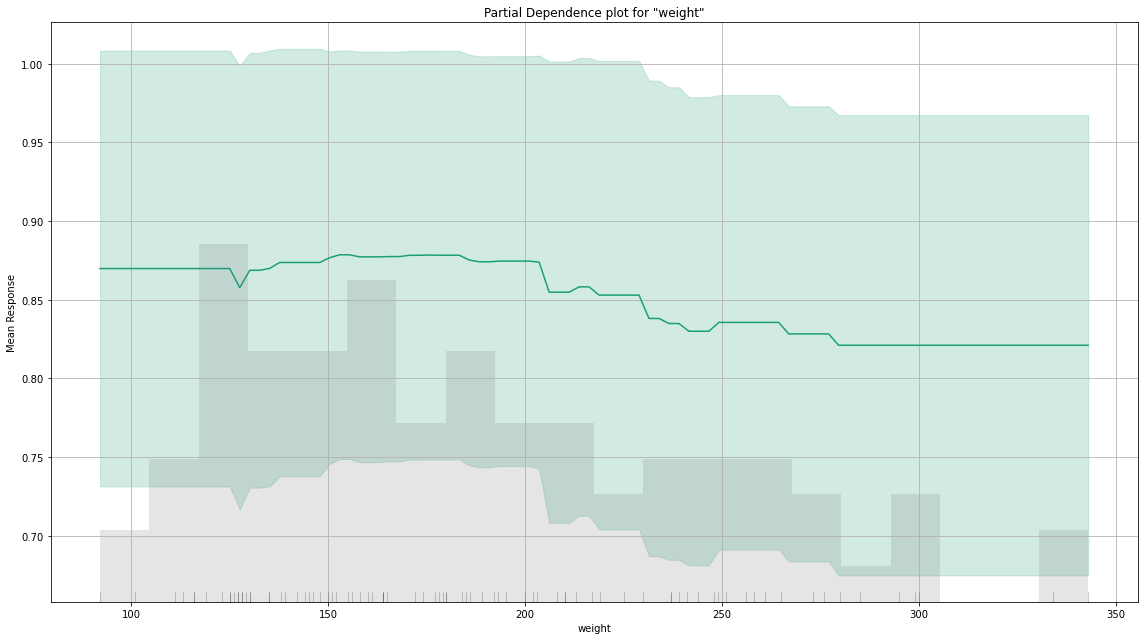

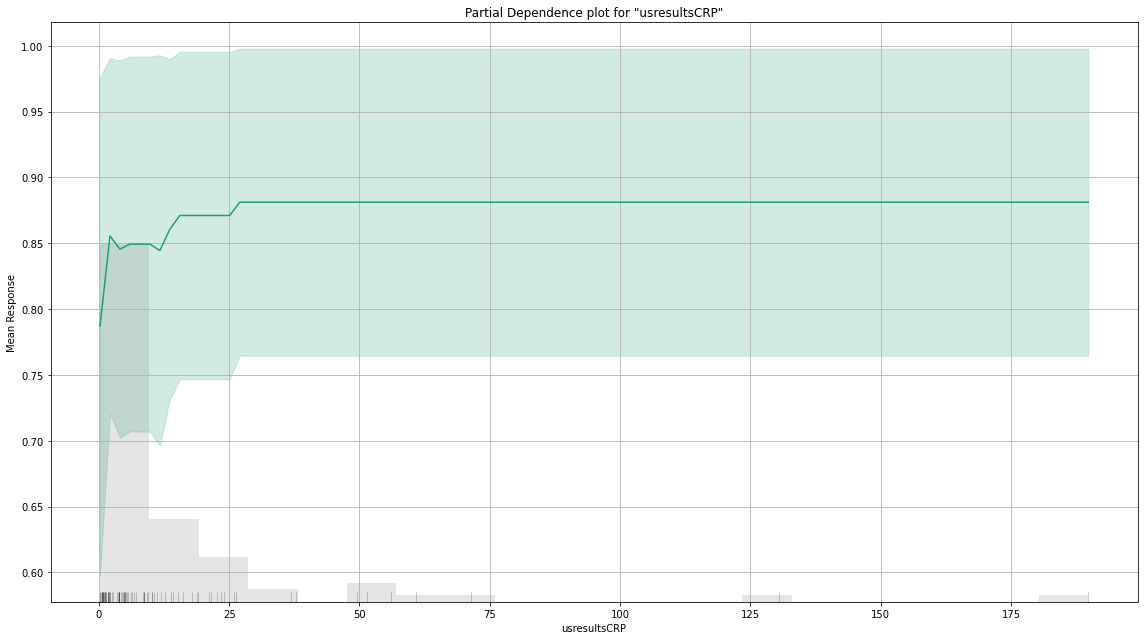

In [34]:
# Explain an AutoML object
exa = aml.leader.explain(test_h2o)